# Example Notebook for TAFT
## Time alignment for tiles 

In [1]:
%cd ..

/home/maximilian/Github/melp


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from melp import Detector
import melp.taft

Welcome to JupyROOT 6.24/06


## Creating/Loading detector with misalignment

In [4]:
#mu3e_detector = Detector.initFromROOT("./run42_20000.root")
mu3e_detector = Detector.initFromSave("best_cal_1.det")

------------------------------
Detector information

Stats:
  - Tiles:  5824
    -> misal:  True
  - Pixel Modules:  2844
  - Loaded Runs (Tiles):  []
  - Loaded Runs (Pixel):  []
------------------------------


In [5]:
melp.taft.select(mu3e_detector)

## Plotting time misalignment distribution

In [6]:
dt = []
for tile in mu3e_detector.TileDetector.tile:
    dt.append(mu3e_detector.TileDetector.tile[tile].dt_truth)

In [7]:
dt = np.array(dt)

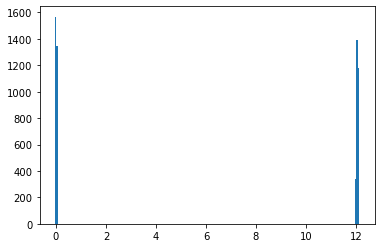

In [8]:
plt.hist(dt, bins=200)
plt.show()

In [9]:
master_tile = mu3e_detector.TileDetector.tile[200000].dt_truth
for tile_id in mu3e_detector.TileDetector.tile:
    tile = mu3e_detector.TileDetector.tile[tile_id]
    tile.dt_truth -= tile.dt_cal + master_tile
    tile.dt_cal = 0.

In [10]:
mu3e_detector.TileDetector.calibrated = False

# Generating Histograms

In [11]:
options_hist = {
    "histo_options": (40000, -20, 20),  # nbins, min, max (10000, -64, 64)
    "hist_file": "hist_test_2.root",  # histogram save file
    "ttree_loc": "mu3e"   # alignment/
}

In [12]:
#melp.taft.generate_hist("../../Downloads/mu3e_sorted_000002.root", **options_hist)
#melp.taft.generate_hist("./merged.root", **options_hist)

# Calibrating Tile Detector

In [11]:
options_cal = {
    "debug_station": 1,
    "tof": "advanced_new",
    "dt_mode": "median", # median
    "overwrite": True,
    #"hist_file": "histo_2mio_frames_2.root"  # histogram file
    "hist_file": "/run/media/maximilian/Volume/merged.root",

    "ttree_loc": "alignment/mu3e",
    "mc_primary": True,
    "cosmic_file": "/run/media/maximilian/Volume/mu3e_sorted_000002_cosmic.root"
}

In [12]:
resid_z, resid_phi, cal_z, cal_phi = melp.taft.calibrate(**options_cal)

Using  median
Calculating absolute timing offsets to master tile: 200000
Calculating absolute timing offsets to master tile: 300000
analyzing cosmics file #1
analyzing cosmics file #299840
done% | Total Frames:  4999840
Calibration finished
Elapsed time: 555.2795 seconds


/home/maximilian/Github/melp/melp/taft/calibrate.py:443: UserWarning: Warning: deprecated
  warnings.warn("Warning: deprecated")
/home/maximilian/Github/melp/melp/taft/calibrate.py:379: UserWarning: Warning: deprecated
  warnings.warn("Warning: deprecated")


In [13]:
#mu3e_detector.save("calibrated_detector_tmp_meadian.taft")

In [14]:
resid_z = np.array(resid_z)
resid_phi = np.array(resid_phi)

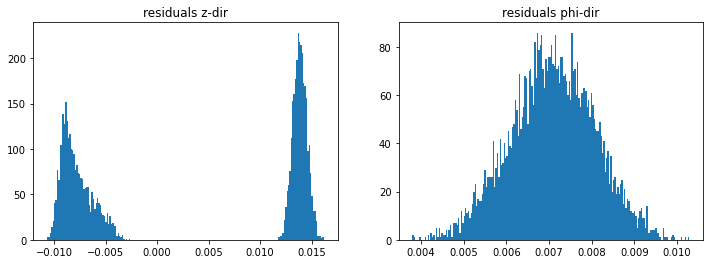

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(resid_z, bins=200)
axs[0].title.set_text("residuals z-dir")
axs[1].hist(resid_phi, bins=200)
axs[1].title.set_text("residuals phi-dir")
plt.show()

### small data sets results in empty histograms between some tiles
#### -> big jumps in dt

## Result for z-direction (station 1)

In [16]:
cal1 = {}
for phi_row in range(56):
    dt_truth = [0]
    for tile in range(0, 51):
        
        tile_id = 200000 + phi_row + tile * 56

        dt_tmp = (mu3e_detector.TileDetector.tile[tile_id].dt_truth -
                   mu3e_detector.TileDetector.tile[mu3e_detector.TileDetector.getNeighbour(tile_id, "right")].dt_truth)
        dt_truth.append(dt_truth[-1] + dt_tmp)

    cal1[phi_row] = np.array(dt_truth)

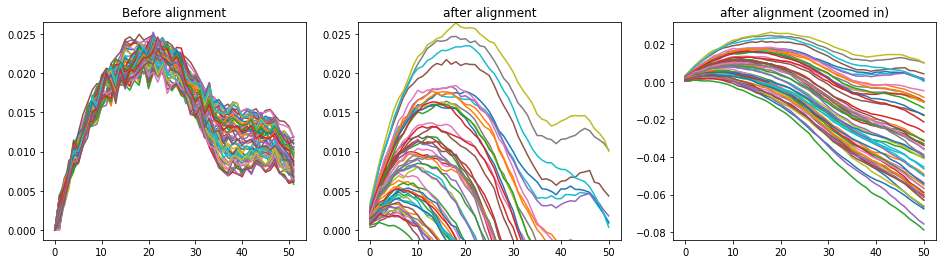

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

for phi in cal1:
    axs[0].plot(np.array(cal1[phi], dtype=object))

axs[0].autoscale()
axs[0].title.set_text("Before alignment")

for phi in cal_z:
    axs[1].plot(cal_z[phi])

axs[1].set_ylim(axs[0].get_ylim())
axs[1].title.set_text("after alignment")

for phi in cal_z:
    axs[2].plot(cal_z[phi])

axs[2].title.set_text("after alignment (zoomed in)")
plt.show()

## Result for phi-direction

In [18]:
cal2 = {}
for z_column in range(52):
    dt_truth = [0]
    for tile in range(0, 56):
        
        tile_id = (200000 + z_column*56 + tile)

        dt_tmp = (mu3e_detector.TileDetector.tile[tile_id].dt_truth -
                   mu3e_detector.TileDetector.tile[mu3e_detector.TileDetector.getNeighbour(tile_id, "up")].dt_truth)
        dt_truth.append(dt_truth[-1] + dt_tmp)

    cal2[z_column] = np.array(dt_truth)

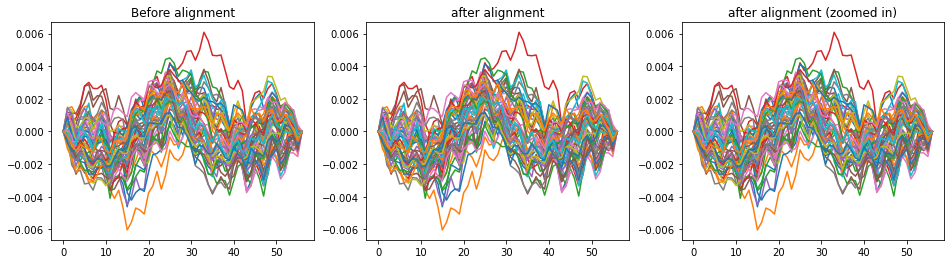

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

for phi in cal2:
    axs[0].plot(cal2[phi])

axs[0].autoscale()
axs[0].title.set_text("Before alignment")

for phi in cal_phi:
    axs[1].plot(cal_phi[phi])

axs[1].set_ylim(axs[0].get_ylim())
axs[1].title.set_text("after alignment")

for phi in cal_phi:
    axs[2].plot(cal_phi[phi])

axs[2].title.set_text("after alignment (zoomed in)")
plt.show()

# Calibrated station

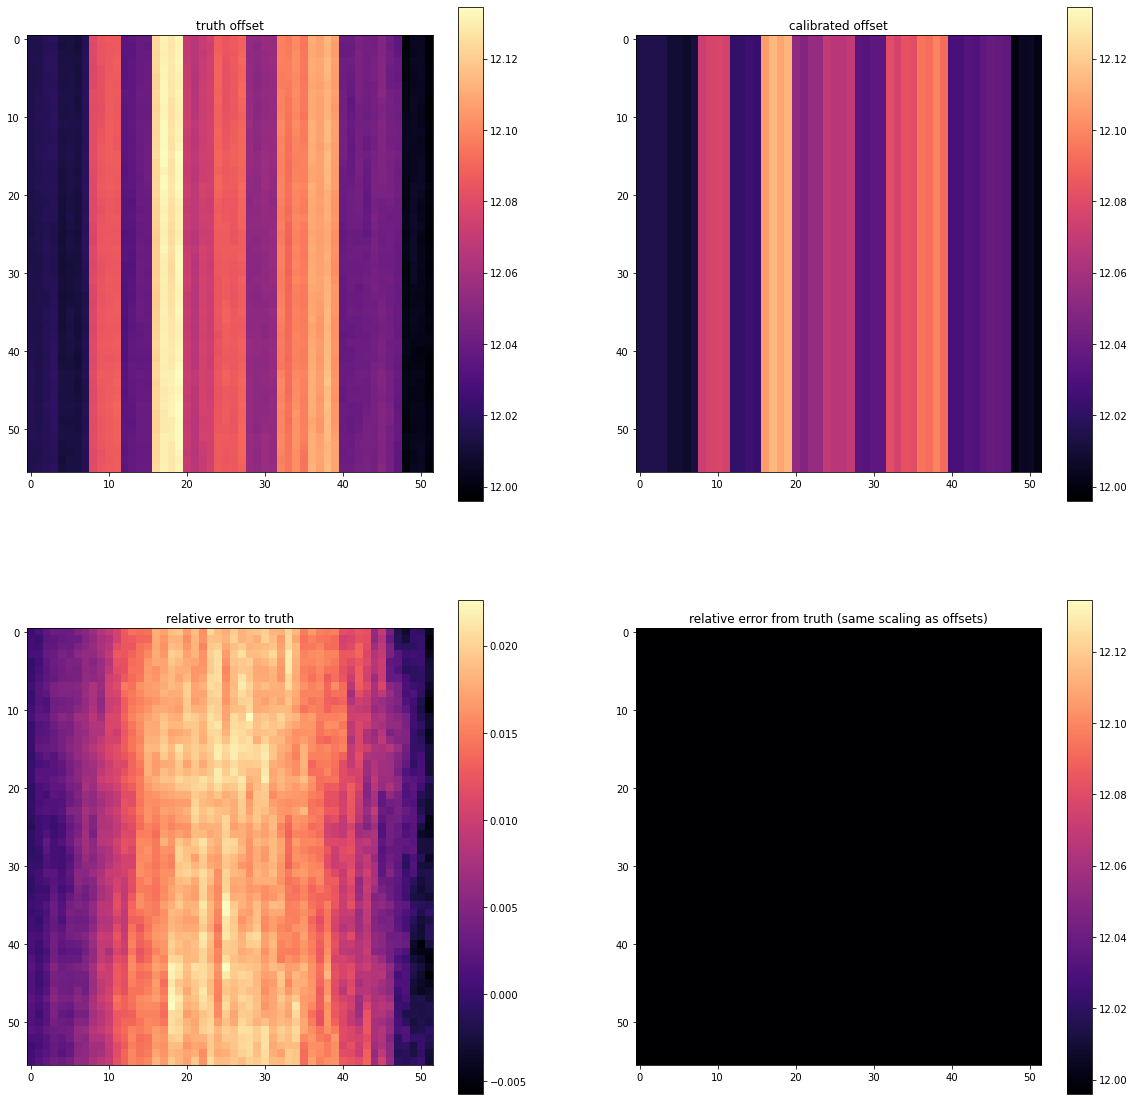

In [7]:
melp.taft.plot_station_calibration(mu3e_detector, 2)

In [23]:
mu3e_detector.save("best_cal_1.det")